## Evaluation Results

In [1]:
from utils.database import *
from utils.files import *
from tqdm import tqdm
from bson import ObjectId
import pandas as pd 
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features
from huggingface_hub import InferenceClient
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from utils.preprocessing import *
from utils.accelerators import *
from utils.multithreading import *
from utils.database import *
from utils.model import *
from utils.files import *
from datasets import Dataset
from tqdm import tqdm
import statistics
import hashlib
import random
import time
import math
import re

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Class Name to ID Mappings

In [2]:
id_to_class = {0: "other", 1: "cannabis", 2: "energie", 3: "kinder"}
class_to_id = {"other": 0, "cannabis": 1, "energie": 2, "kinder": 3}

### Load Dataset

In [3]:
MAX_CONTENT_LENGTH = 384
file_path = f"../data/tmp/processed_dataset_multiclass_chunkified_{MAX_CONTENT_LENGTH}_2_preds"
dataset = load_from_disk(file_path)

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'token_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'chunk_id', 'url_path', 'input_ids', 'attention_mask', 'probas', 'preds'],
        num_rows: 7833
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'token_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'chunk_id', 'url_path', 'input_ids', 'attention_mask', 'probas', 'preds'],
        num_rows: 827645
    })
    valid: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'token_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'chunk_id', 'url_path', 'input_

In [5]:
dataset = dataset["test"]

## Merge Chunk Level Predictions

In [6]:
# Group dataset examples by URL, with a fallback to domain
grouped_dataset = {}
for example in tqdm(dataset):
    url = example.get("view_url") or example.get("domain")
    example_filtered = {k: example[k] for k in ["text", "probas", "preds", "label", "category", "annotation_type", "lang"]}
    grouped_dataset.setdefault(url, []).append(example_filtered)

100%|██████████| 827645/827645 [08:03<00:00, 1711.42it/s]


In [ ]:
filtered_grouped_dataset = {url: examples for url, examples in grouped_dataset.items() if len(examples[0].get("text", "")) > 0}

In [7]:
len(list(grouped_dataset.keys()))

143140

In [8]:
list(grouped_dataset.keys())[0:5]

['www.google.com/',
 'email.t-online.de/em#f=INBOX&m=14788888321797910&method=showReadmail',
 'surveyd.bilendi.com/survey/selfserve/53b/2306124?list=1&ID=247646250822832&t=2&r=2#?',
 'surveyd.bilendi.com/survey/selfserve/53b/2306124#$',
 'surveyd.bilendi.com/survey/selfserve/53b/2306124#&']

In [9]:
list(grouped_dataset.values())[0][0]

{'text': 'Klicke hier , wenn du nach einigen Sekunden nicht automatisch weitergeleitet wirst',
 'probas': [0.9988507032394409,
  9.518926526652649e-05,
  0.0007952007581479847,
  0.00025887321680784225],
 'preds': 0,
 'label': 0,
 'category': 'other',
 'annotation_type': 'domain_discarded',
 'lang': 'de'}

## Extract Label

In [10]:
# Extract labels
labels_for_url = []
for url, chunks in grouped_dataset.items():
    preds = [chunk["label"] for chunk in chunks]
    labels_for_url.append(max(preds))

## Predictions on Chunk Level

In [11]:
preds = dataset["preds"]
labels = dataset["label"]

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_frequencies(labels, preds, id_to_class):
    """Plot class frequencies for both true labels and predictions using class names."""
    
    # Count the frequencies of each class in labels and predictions
    label_freq = Counter(labels)
    pred_freq = Counter(preds)

    # Get a sorted list of all unique classes across both labels and preds for consistent plotting
    all_classes = sorted(set(labels) | set(preds), key=lambda x: id_to_class.get(x, 'Unknown Class'))

    # Prepare data for plotting with class names instead of IDs
    label_counts = [label_freq.get(cls, 0) for cls in all_classes]
    pred_counts = [pred_freq.get(cls, 0) for cls in all_classes]
    class_labels = [id_to_class.get(cls, 'Unknown Class') for cls in all_classes]

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.30  # width of bars

    index = range(len(all_classes))
    bars1 = ax.bar(index, label_counts, bar_width, label='True Labels')
    bars2 = ax.bar([p + bar_width for p in index], pred_counts, bar_width, label='Predictions')

    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.set_title('Class Frequencies in Labels and Predictions')
    ax.set_xticks([p + bar_width / 2 for p in index])
    ax.set_xticklabels(class_labels, rotation=45, ha="right")  # rotated for better visibility if names are long
    ax.legend()

    plt.tight_layout()  # Adjust layout to make room for tick label rotation
    plt.show()


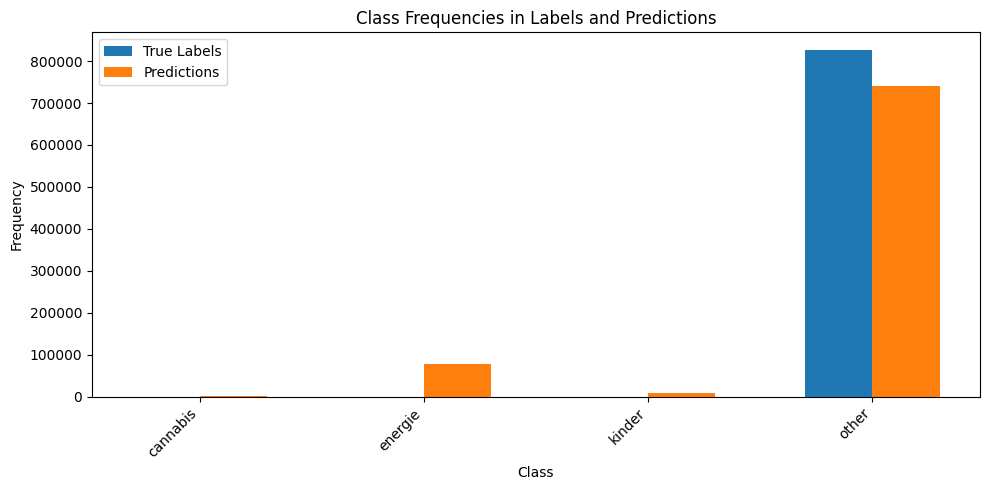

In [13]:
plot_class_frequencies(labels, preds, id_to_class)

In [14]:
def compute_metrics(labels, preds, average='micro'):
    """Compute and print classification metrics: accuracy, precision, recall, and F1 score."""
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average=average)
    recall = recall_score(labels, preds, average=average)
    f1 = f1_score(labels, preds, average=average)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

In [15]:
compute_metrics(labels, preds)

Accuracy: 89.60%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, id_to_class):
    """Plot a confusion matrix with class names using seaborn."""
    
    # Generate the confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Create a list of class names in the order they appear in the id_to_class dictionary
    class_names = [id_to_class[i] for i in sorted(id_to_class.keys())]

    # Create and display a seaborn heatmap with annotations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

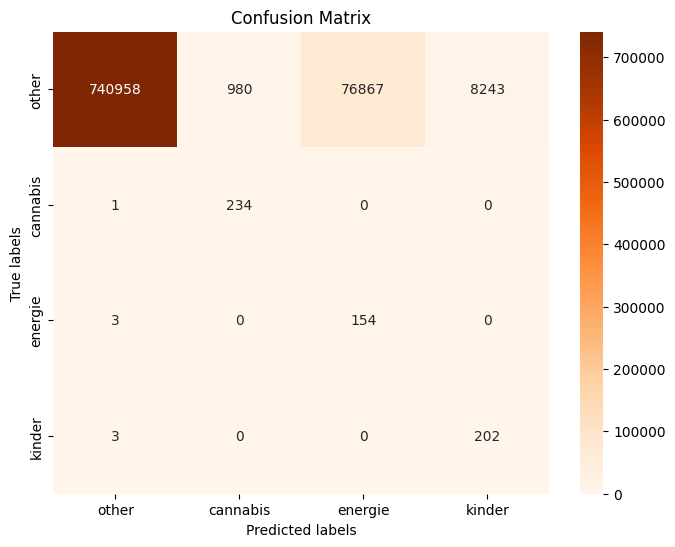

In [17]:
plot_confusion_matrix(labels, preds, id_to_class)

## Predictions on Page Level: Maximum Label
Classifying the entire document as in-class if at least one chunk of the document is identified as policy relevant.

In [18]:
def majority_voting(answers):
    """Apply majority voting to a list of arbitrary classification answers."""
    count = Counter(answers)
    most_common = count.most_common()  # Get all common answers sorted by frequency

    if not most_common:
        return 0 # Handle empty input scenario

    # Check for ties at the highest count
    max_votes = most_common[0][1]
    tied_classes = [cls for cls, votes in most_common if votes == max_votes]

    if len(tied_classes) > 1:
        return max(tied_classes)  # Return the maximum class label in case of a tie
    return tied_classes[0]  # Return the class with the most votes

majority_voting([1, 1, 2, 2, 2, 3])

2

In [19]:
prediction_for_url_max = []

# It is kinda nuts that max() works best but the intuition is that most chunks are other and as soon there is anything higher than other (class label 0) it is always related to that policy
for url, chunks in grouped_dataset.items():
    preds = [chunk["preds"] for chunk in chunks]
    pred = majority_voting([pred for pred in preds if pred > 0]) if max(preds) > 0 else 0
    prediction_for_url_max.append(pred)
    

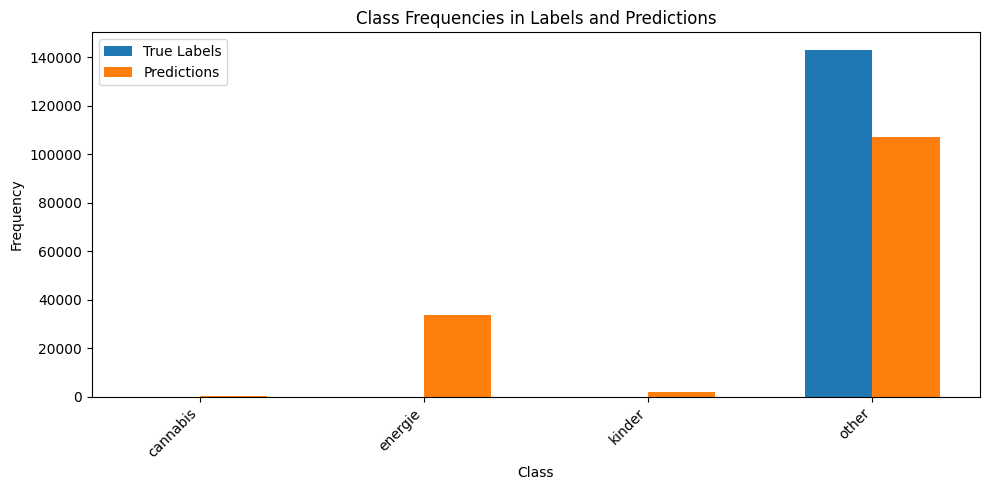

In [20]:
plot_class_frequencies(labels_for_url, prediction_for_url_max, id_to_class)

In [21]:
compute_metrics(labels_for_url, prediction_for_url_max)

Accuracy: 74.99%
Precision: 0.75
Recall: 0.75
F1 Score: 0.75


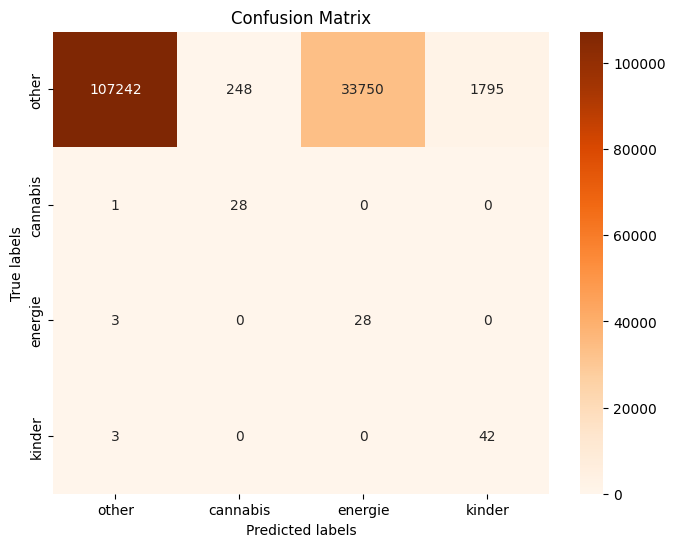

In [22]:
plot_confusion_matrix(labels_for_url, prediction_for_url_max, id_to_class)

## Per Category

In [23]:
categories = []

for url, chunks in grouped_dataset.items():
    category = [chunk["category"] for chunk in chunks]
    categories.append(category[0])
    
print(categories[:5])

['other', 'other', 'other', 'other', 'other']


In [24]:
from collections import defaultdict

def group_by_attribute(attributes, labels, predictions):
    """Group labels and predictions by a specified attribute."""
    
    grouped_labels = defaultdict(list)
    grouped_predictions = defaultdict(list)

    for attribute, label, prediction in zip(attributes, labels, predictions):
        grouped_labels[attribute].append(label)
        grouped_predictions[attribute].append(prediction)

    return grouped_labels, grouped_predictions

CATEGORY: other

Accuracy: 73.49%
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


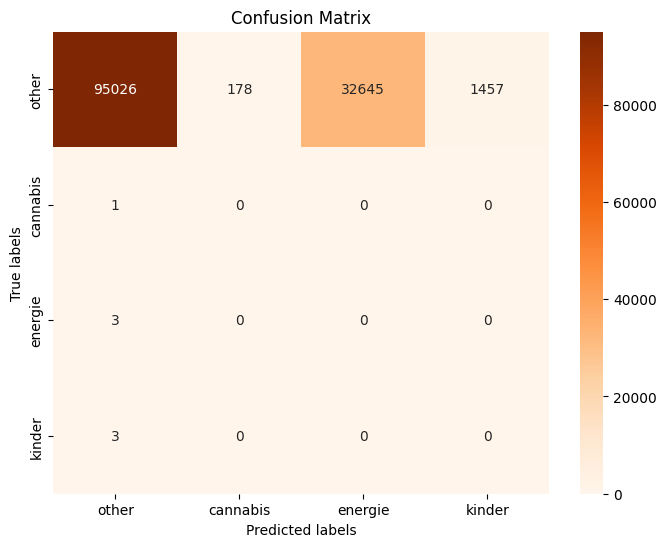



CATEGORY: news

Accuracy: 85.36%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


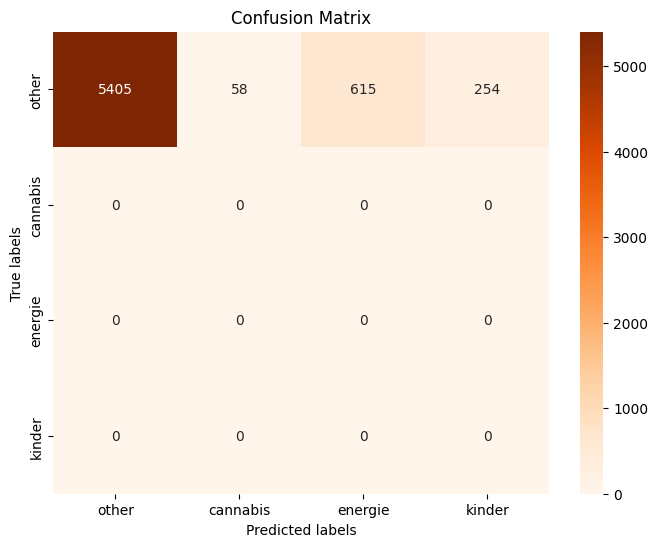



CATEGORY: search

Accuracy: 92.18%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


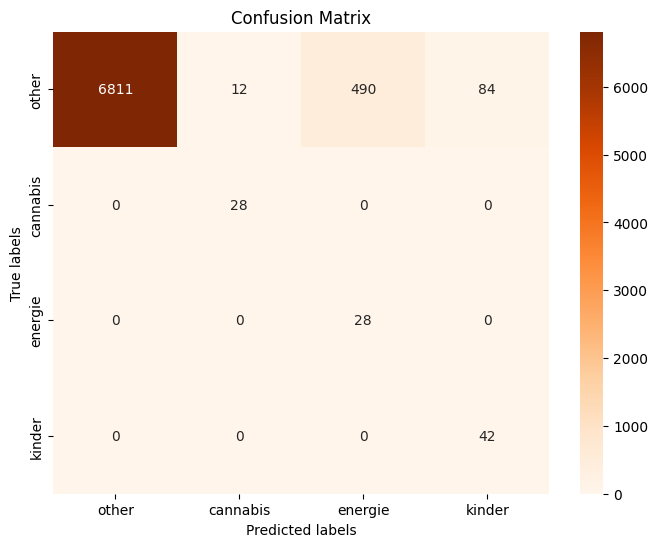

In [25]:
category_labels, category_predictions = group_by_attribute(categories, labels_for_url, prediction_for_url_max)

for category in category_labels:
    print(f"CATEGORY: {category}", end="\n\n")
    compute_metrics(category_labels[category], category_predictions[category])
    #plot_class_frequencies(category_labels[category], category_predictions[category], id_to_class)
    plot_confusion_matrix(category_labels[category], category_predictions[category], id_to_class)
    print("\n")

## Per Annotation Type

In [26]:
annotation_types = []

for url, chunks in grouped_dataset.items():
    annotation_type = [chunk["category"] for chunk in chunks]
    annotation_types.append(annotation_type[0])
    
print(annotation_type[:5])

['other', 'other', 'other', 'other', 'other']


CATEGORY: other

Accuracy: 73.49%
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


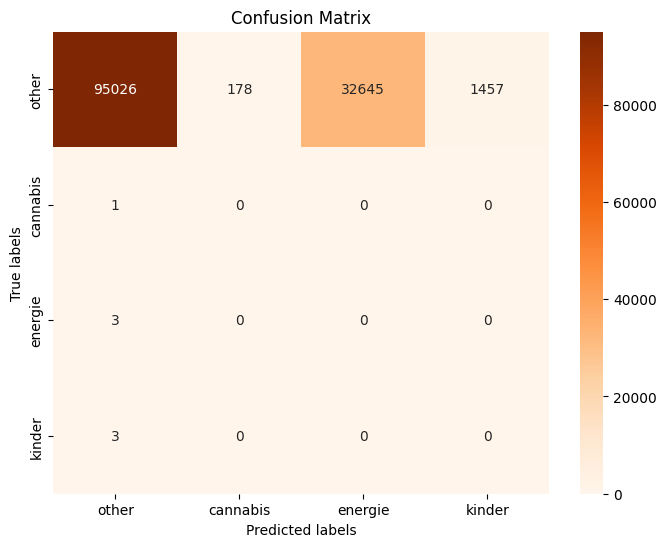



CATEGORY: news

Accuracy: 85.36%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


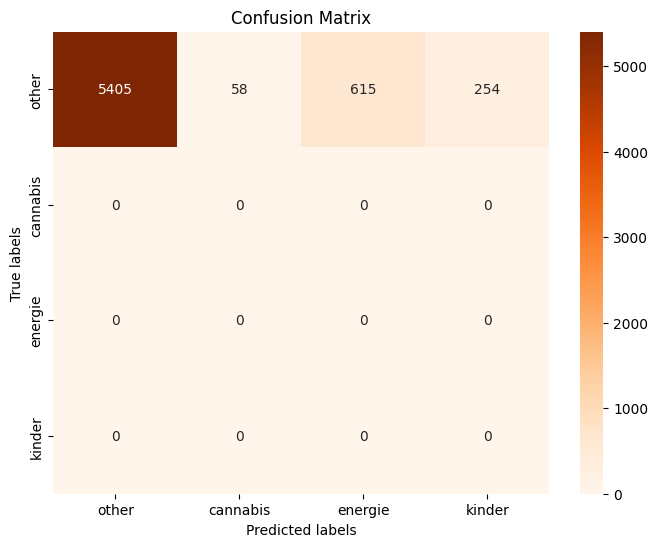



CATEGORY: search

Accuracy: 92.18%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


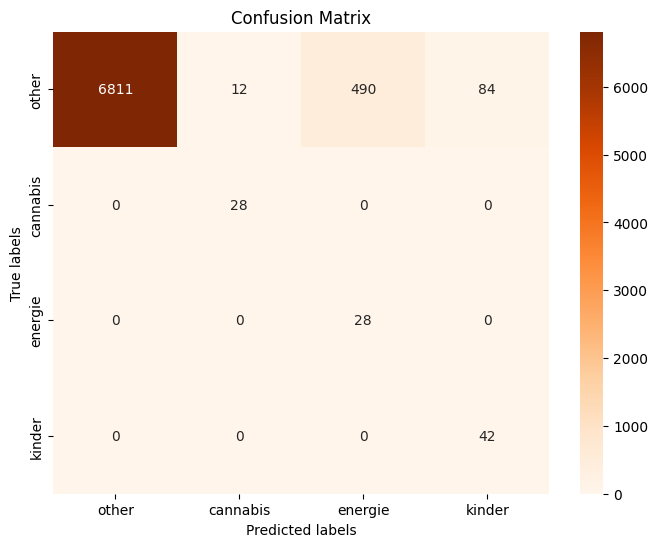

In [27]:
type_labels, type_predictions = group_by_attribute(annotation_types, labels_for_url, prediction_for_url_max)

for type_label in type_labels:
    print(f"CATEGORY: {type_label}", end="\n\n")
    compute_metrics(type_labels[type_label], type_predictions[type_label])
    plot_confusion_matrix(type_labels[type_label], type_predictions[type_label], id_to_class)
    print("\n")

## Per Language

In [28]:
langs = []

for url, chunks in grouped_dataset.items():
    lang = [chunk["lang"] for chunk in chunks]
    langs.append(lang[0])
    
print(langs[:5])

['de', 'de', 'de', 'de', 'de']


CATEGORY: de



Accuracy: 82.14%
Precision: 0.82
Recall: 0.82
F1 Score: 0.82


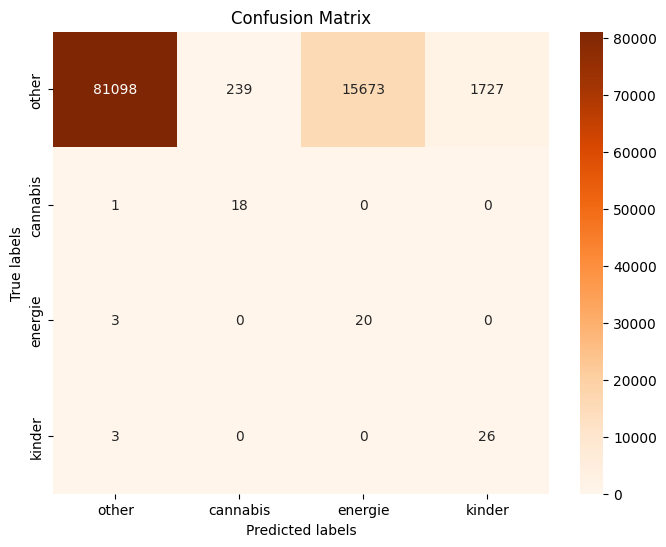



CATEGORY: en

Accuracy: 56.65%
Precision: 0.57
Recall: 0.57
F1 Score: 0.57


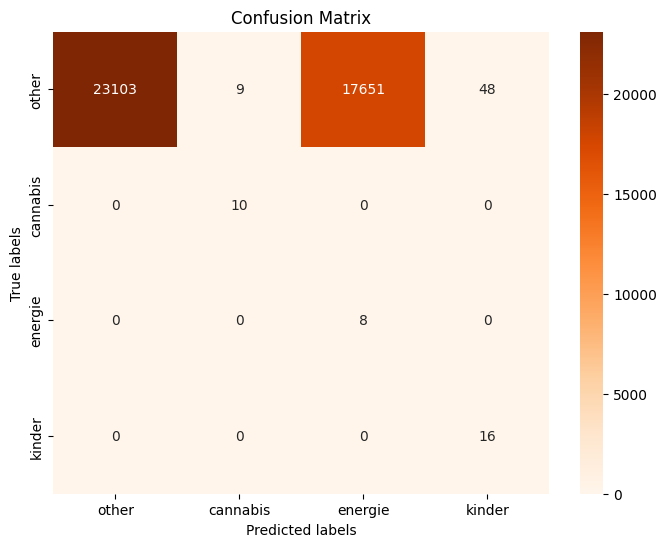



CATEGORY: sk

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


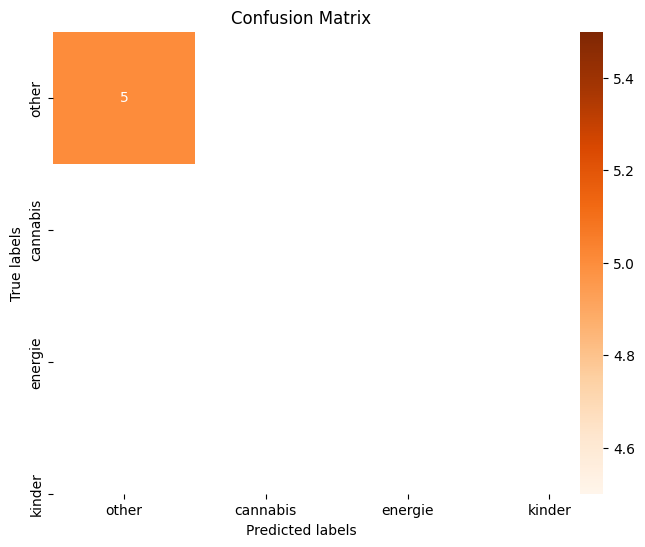



CATEGORY: ru

Accuracy: 93.69%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


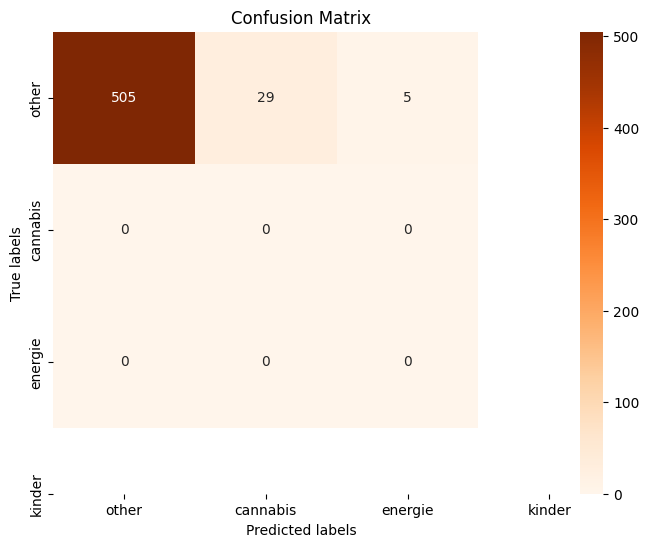



CATEGORY: ro

Accuracy: 89.47%
Precision: 0.89
Recall: 0.89
F1 Score: 0.89


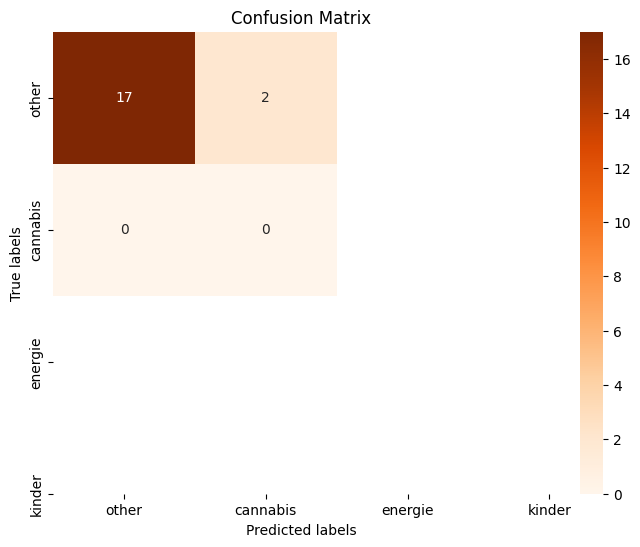



CATEGORY: no

Accuracy: 77.42%
Precision: 0.77
Recall: 0.77
F1 Score: 0.77


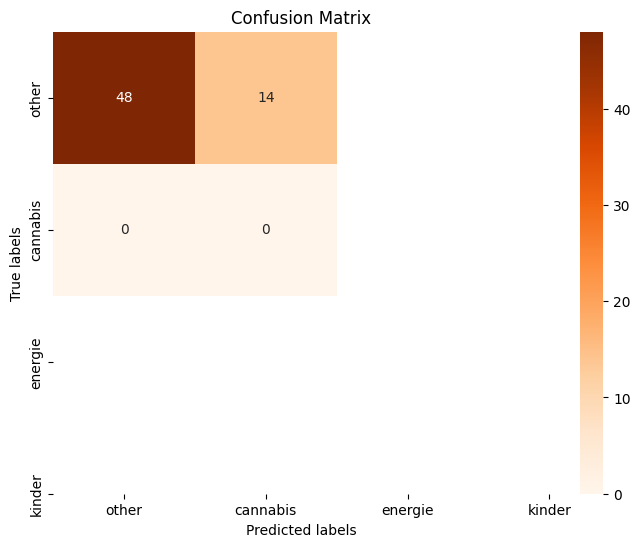



CATEGORY: et

Accuracy: 90.51%
Precision: 0.91
Recall: 0.91
F1 Score: 0.91


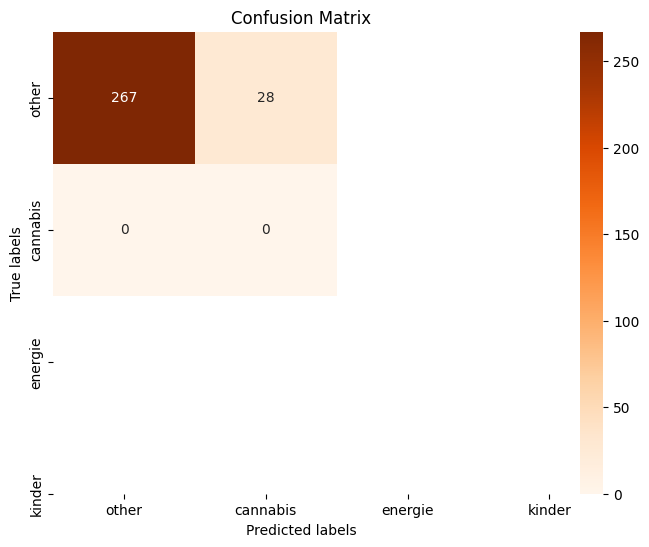



CATEGORY: cs

Accuracy: 97.40%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


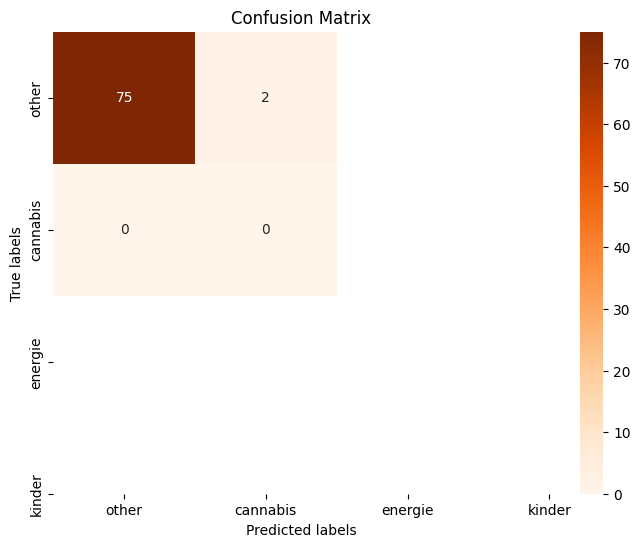



CATEGORY: fr

Accuracy: 72.79%
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


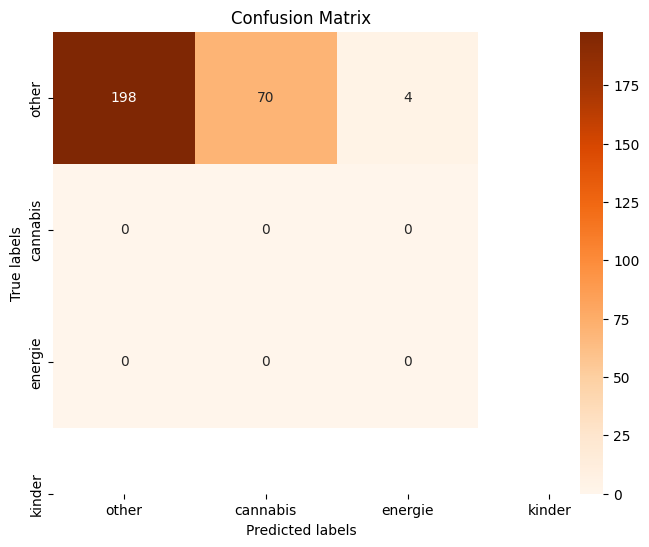



CATEGORY: uk

Accuracy: 50.00%
Precision: 0.50
Recall: 0.50
F1 Score: 0.50


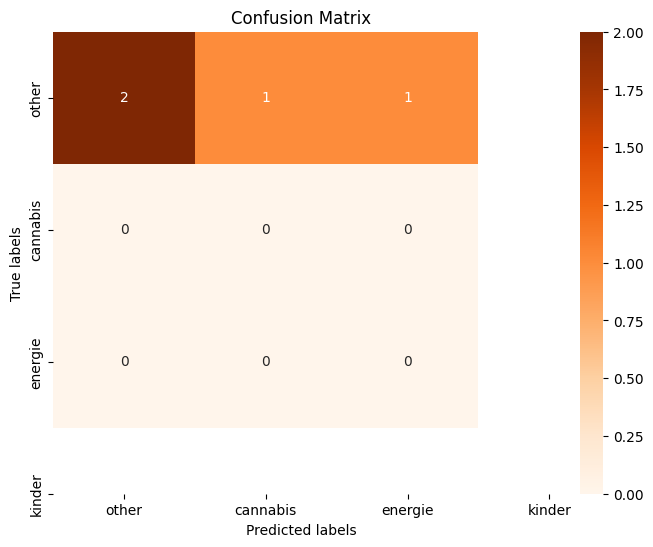



CATEGORY: it

Accuracy: 84.56%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


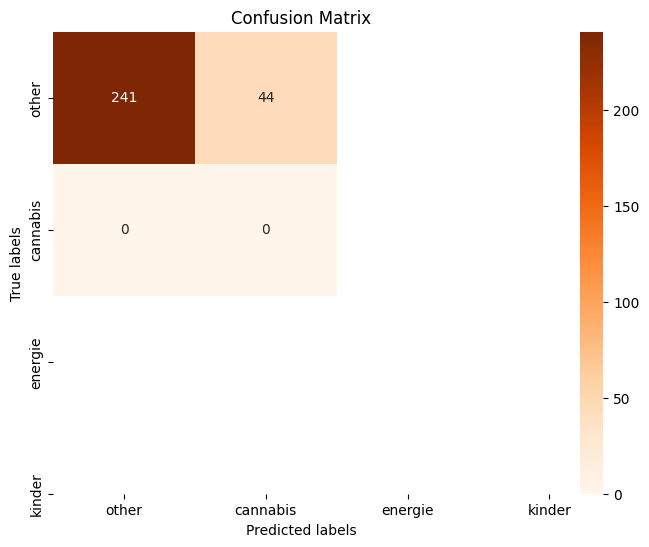



CATEGORY: tl

Accuracy: 89.43%
Precision: 0.89
Recall: 0.89
F1 Score: 0.89


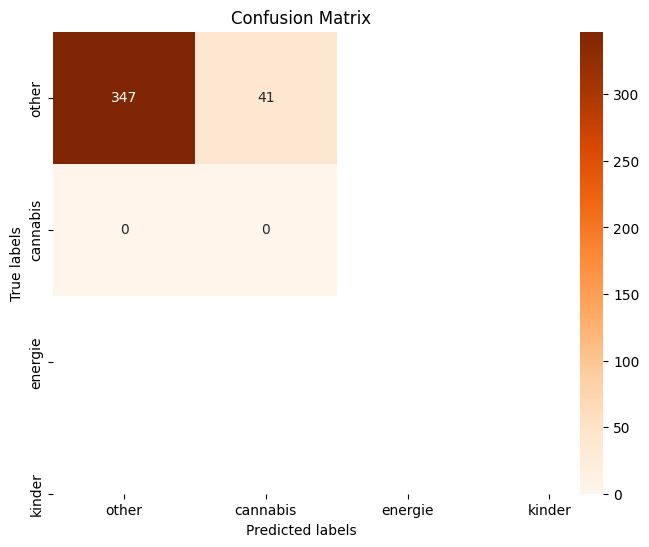



CATEGORY: es

Accuracy: 95.00%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95


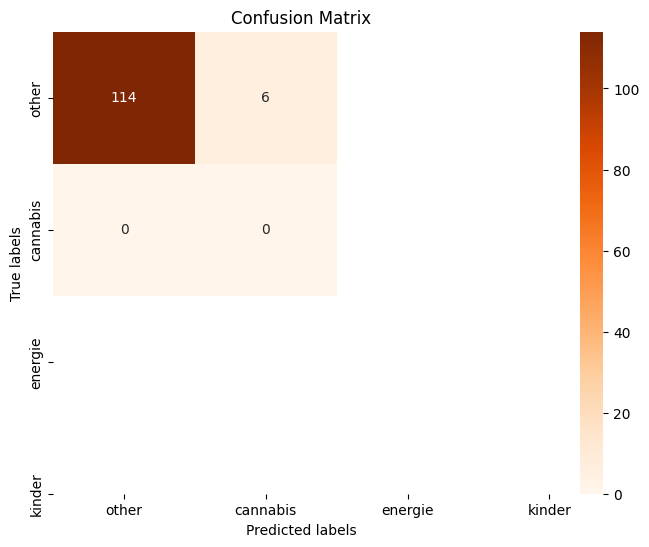



CATEGORY: nl

Accuracy: 95.67%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


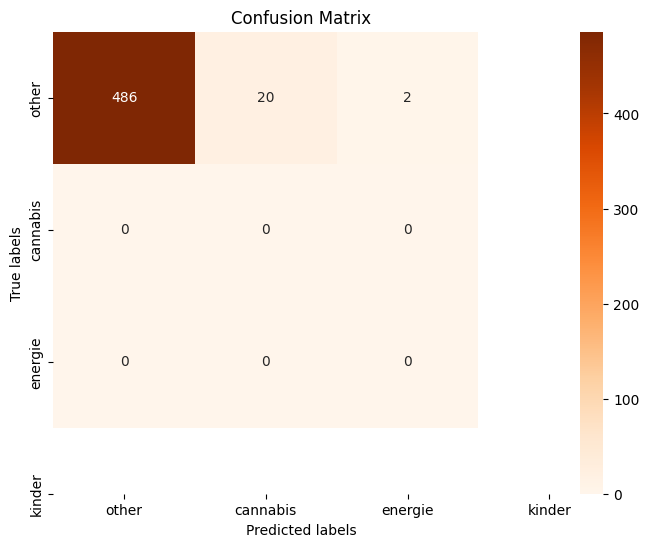



CATEGORY: af

Accuracy: 26.56%
Precision: 0.27
Recall: 0.27
F1 Score: 0.27


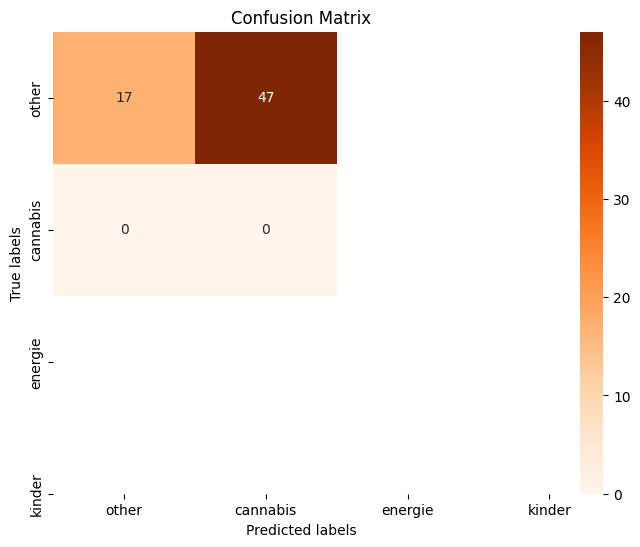



CATEGORY: ca

Accuracy: 74.10%
Precision: 0.74
Recall: 0.74
F1 Score: 0.74


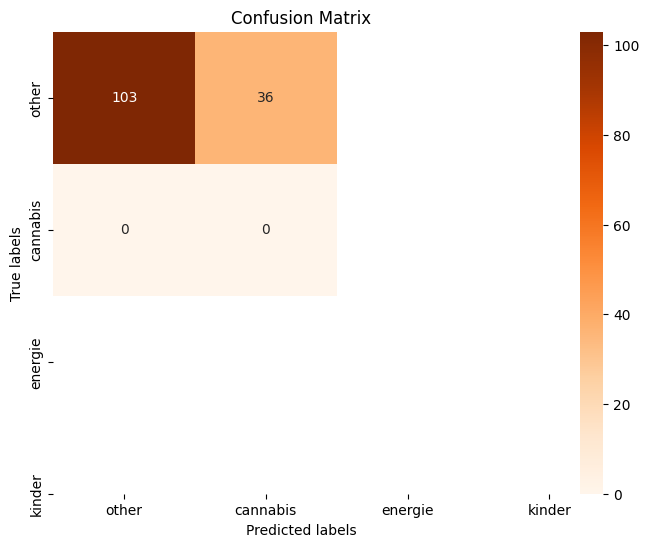



CATEGORY: sl

Accuracy: 93.75%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


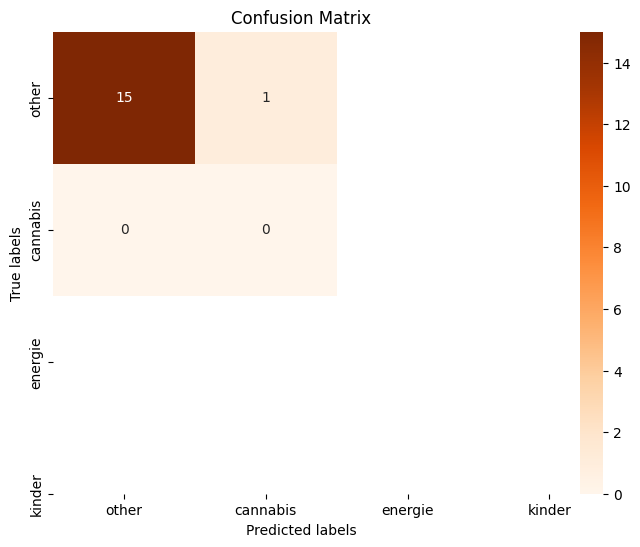



CATEGORY: cy

Accuracy: 90.24%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


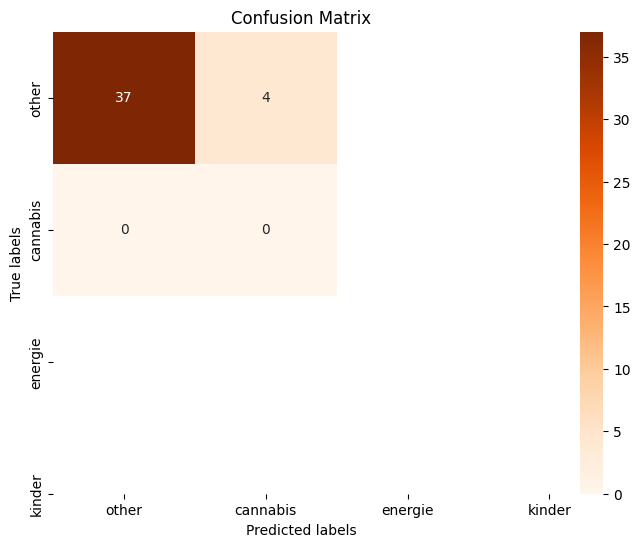



CATEGORY: pl

Accuracy: 66.67%
Precision: 0.67
Recall: 0.67
F1 Score: 0.67


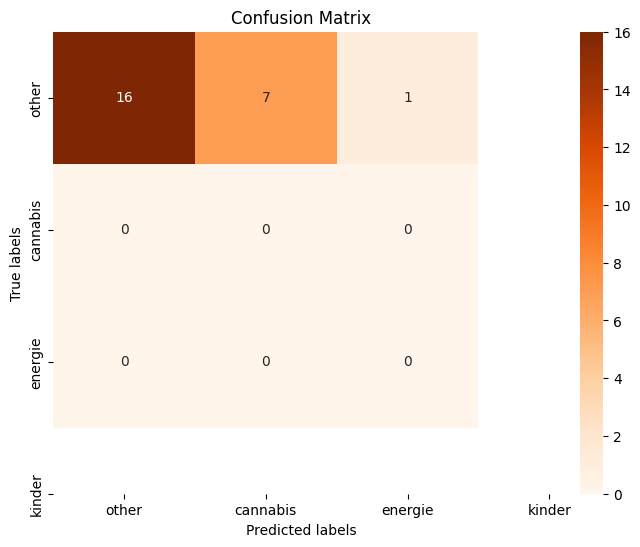



CATEGORY: lv

Accuracy: 42.11%
Precision: 0.42
Recall: 0.42
F1 Score: 0.42


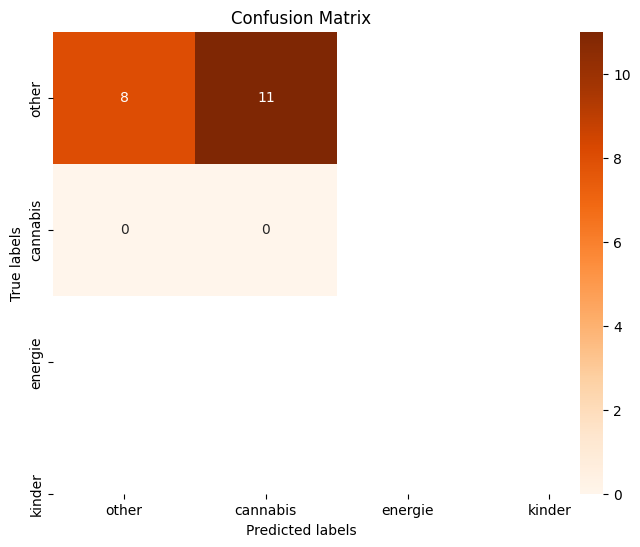



CATEGORY: bg

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


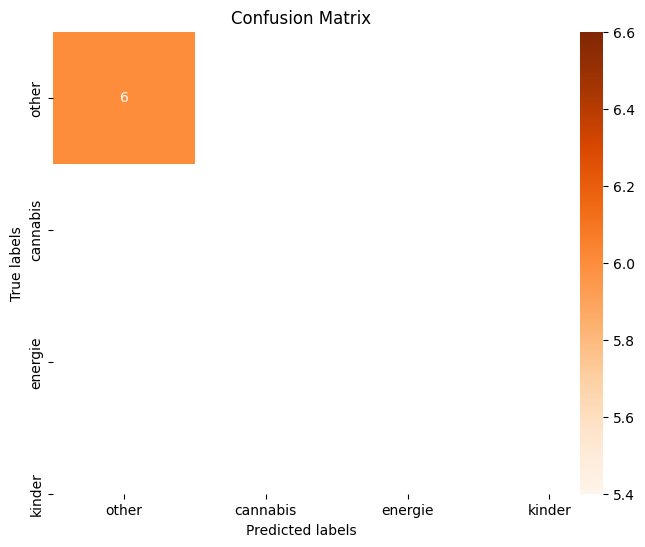



CATEGORY: pt

Accuracy: 95.54%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


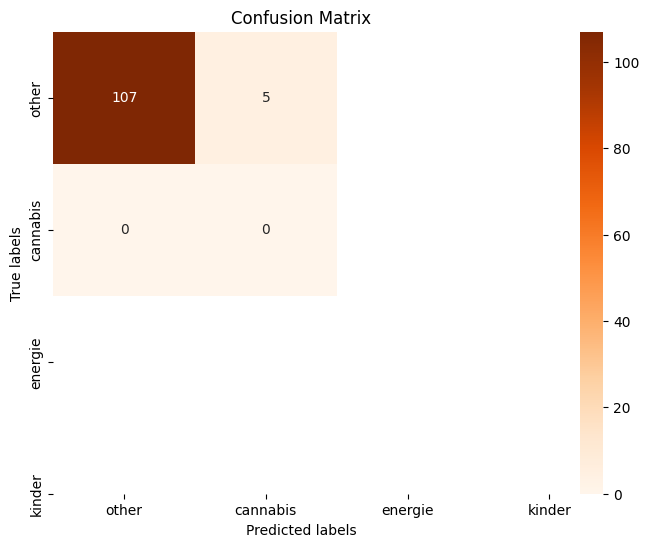



CATEGORY: tr

Accuracy: 88.89%
Precision: 0.89
Recall: 0.89
F1 Score: 0.89


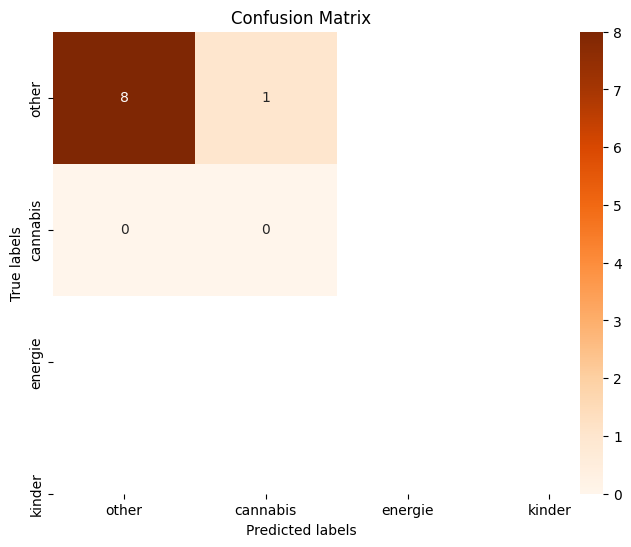



CATEGORY: da

Accuracy: 54.05%
Precision: 0.54
Recall: 0.54
F1 Score: 0.54


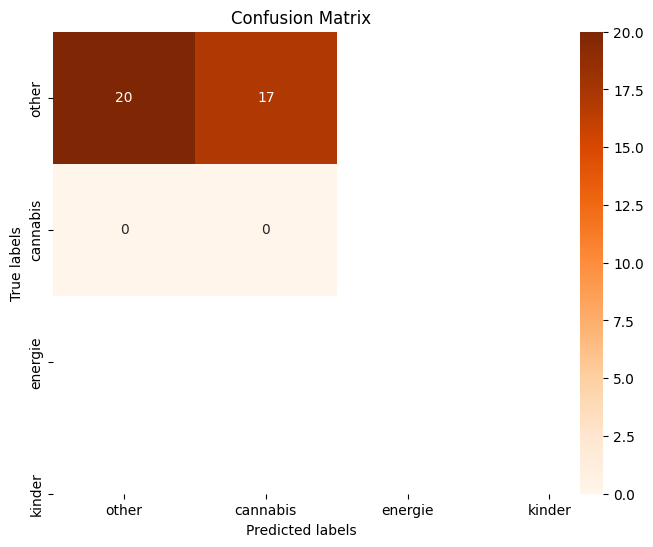



CATEGORY: ko

Accuracy: 94.12%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


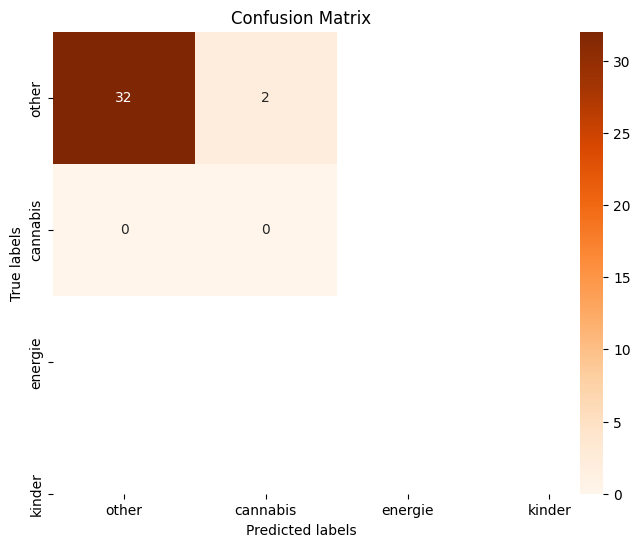



CATEGORY: el

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


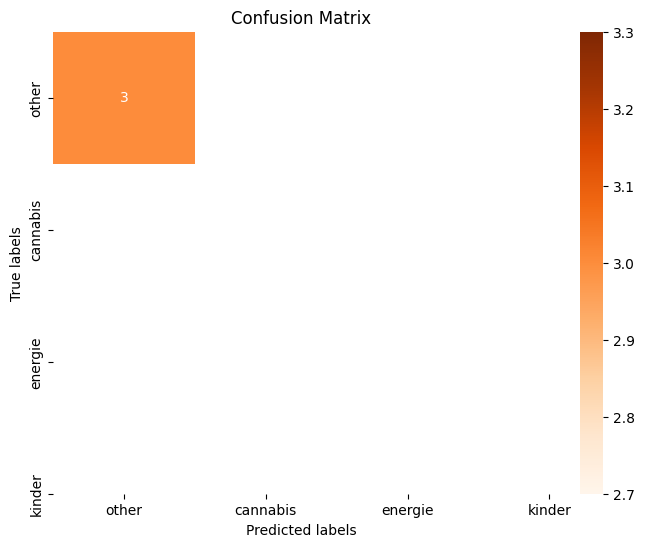



CATEGORY: sv

Accuracy: 82.88%
Precision: 0.83
Recall: 0.83
F1 Score: 0.83


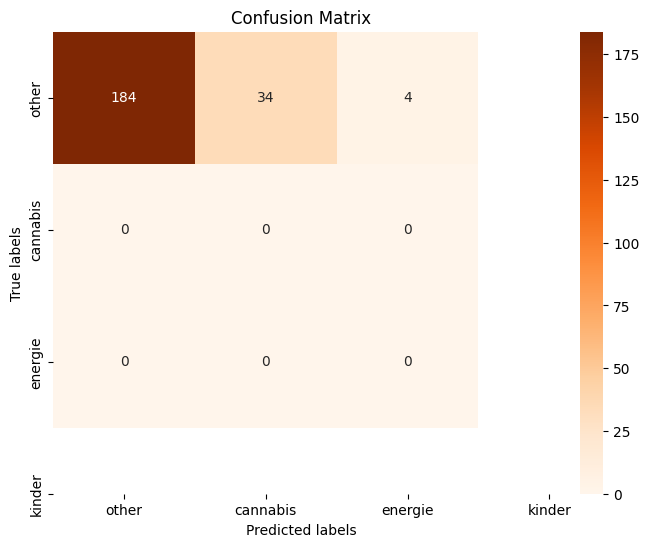



CATEGORY: hu

Accuracy: 96.81%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


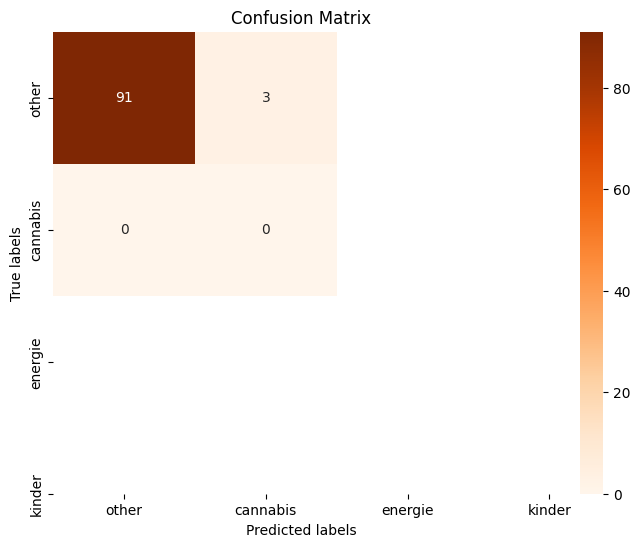



CATEGORY: vi

Accuracy: 75.00%
Precision: 0.75
Recall: 0.75
F1 Score: 0.75


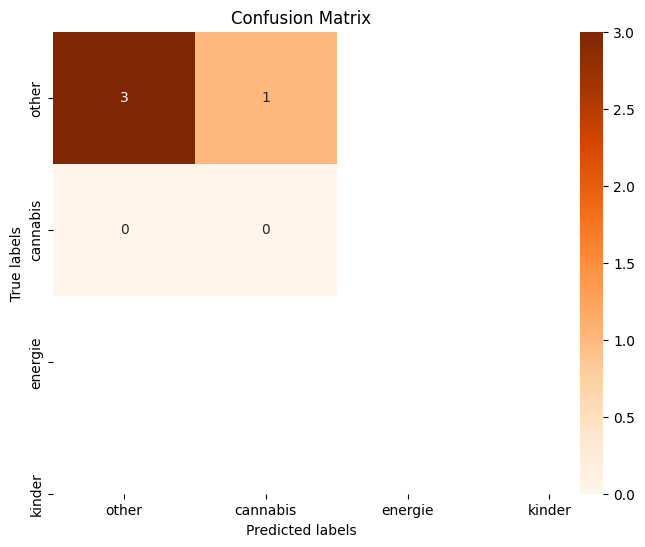



CATEGORY: lt

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


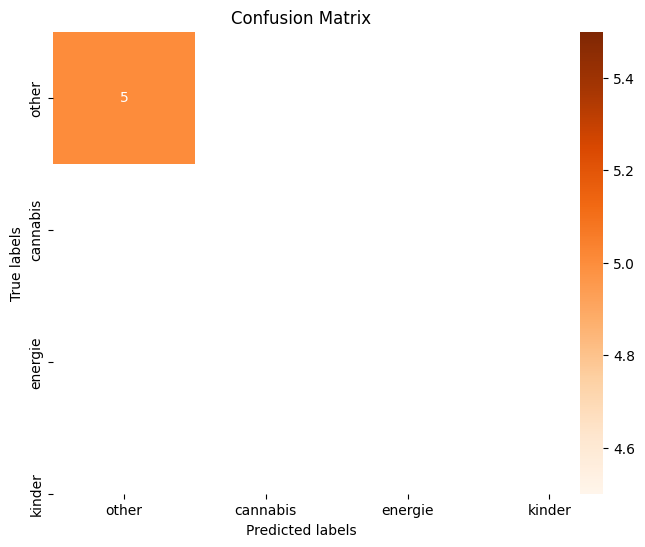



CATEGORY: ja

Accuracy: 96.30%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


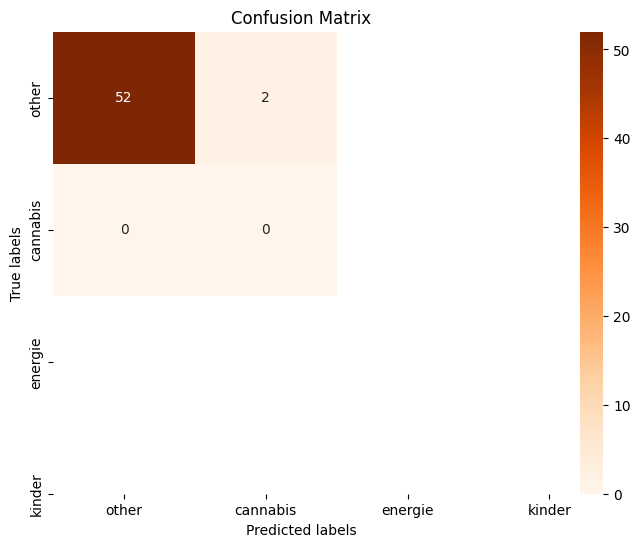



CATEGORY: so

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


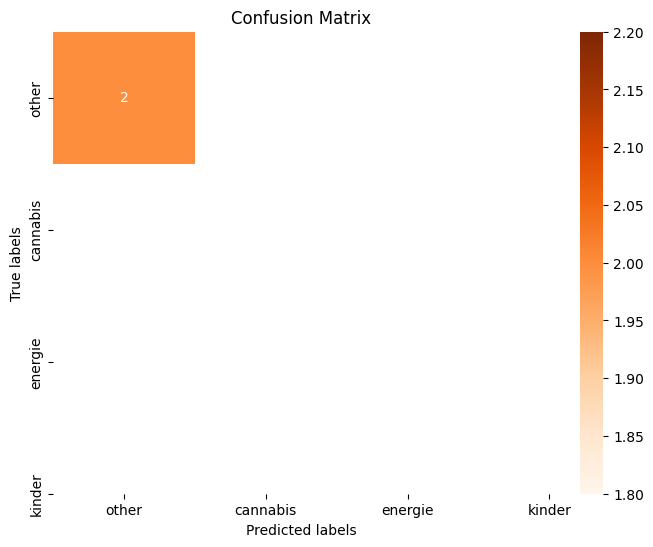



CATEGORY: id

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


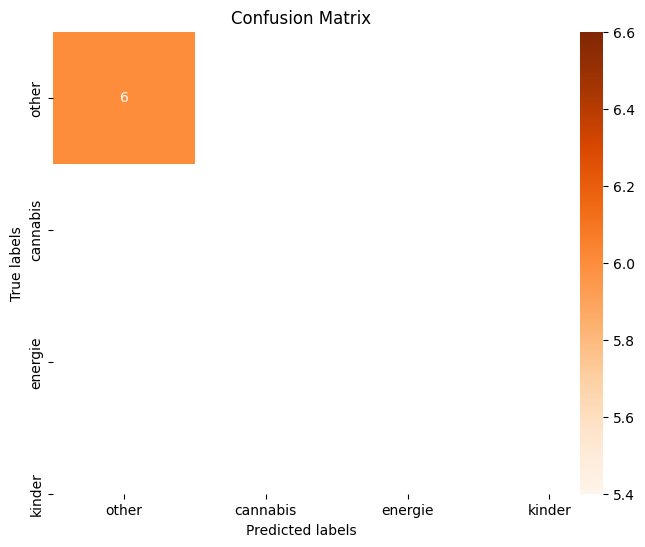



CATEGORY: hr

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


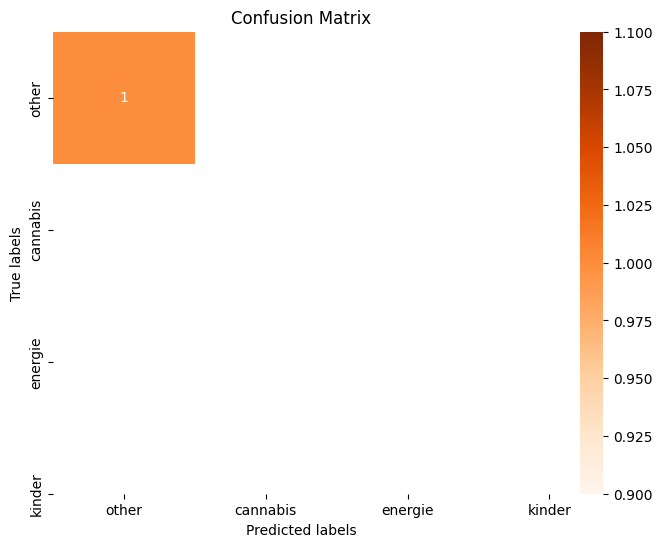



CATEGORY: ar

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


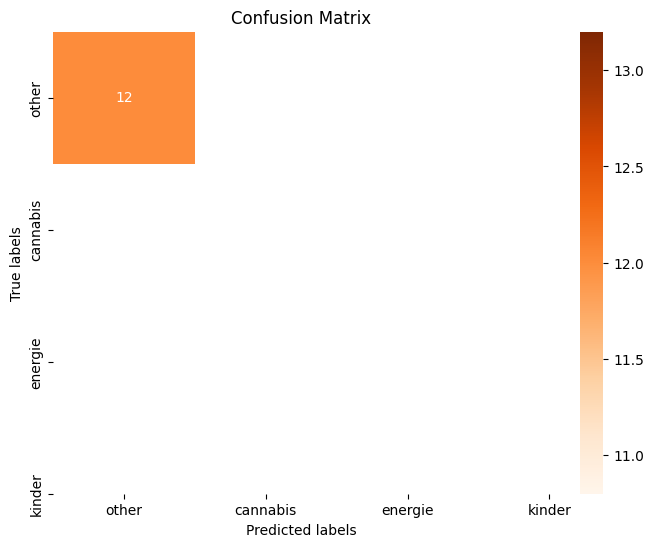



CATEGORY: zh-cn

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


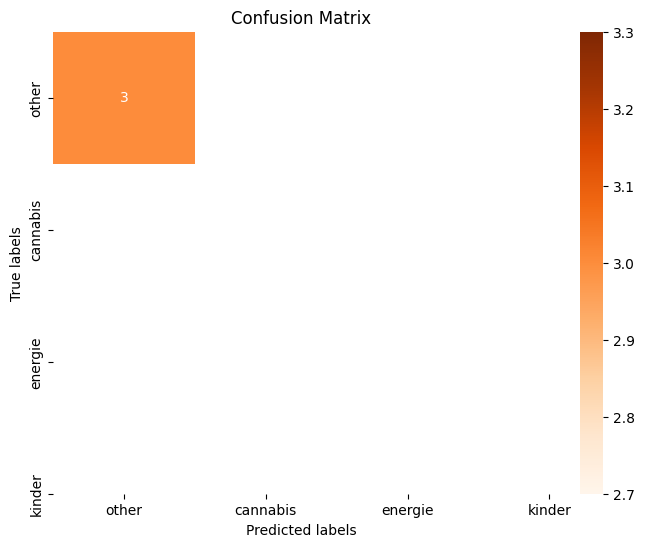



CATEGORY: fi

Accuracy: 50.00%
Precision: 0.50
Recall: 0.50
F1 Score: 0.50


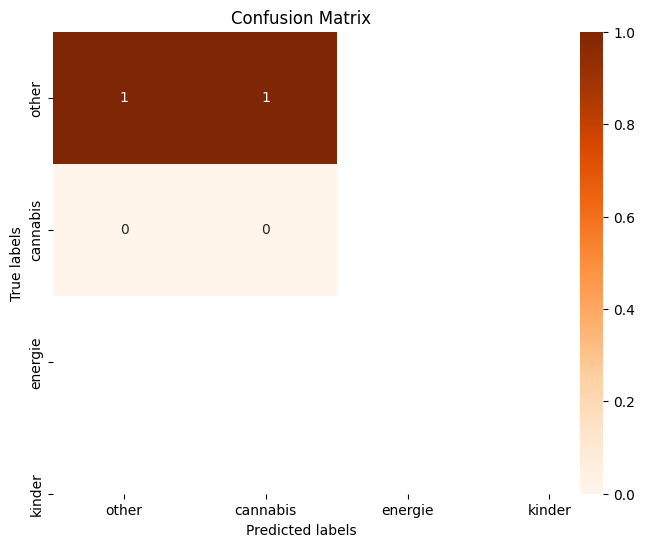



CATEGORY: ur

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


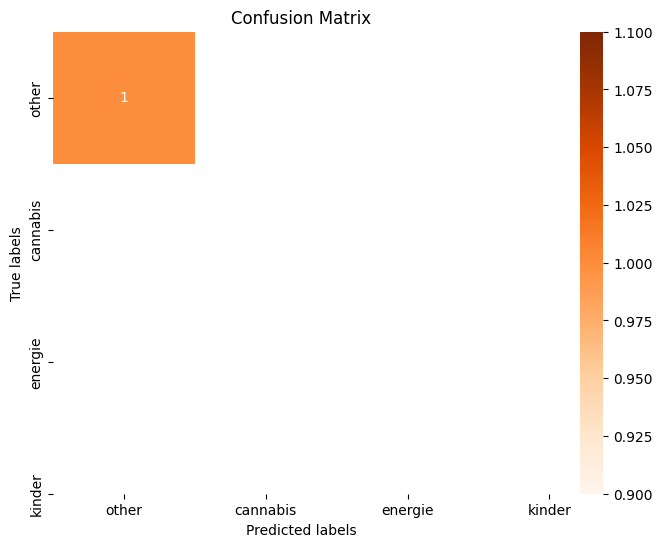



CATEGORY: th

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


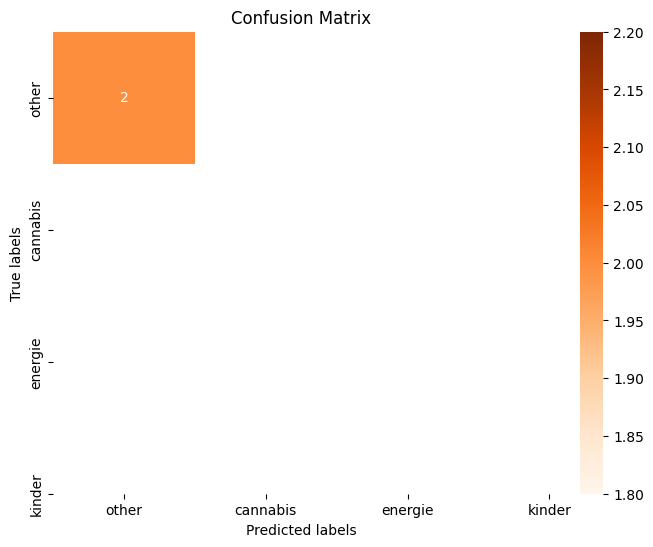



CATEGORY: sw

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


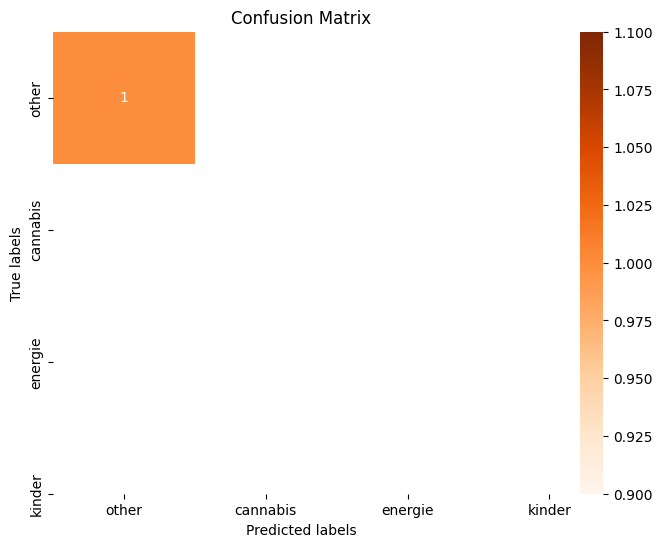

In [29]:
lang_labels, lang_predictions = group_by_attribute(langs, labels_for_url, prediction_for_url_max)

for lang in lang_labels:
    print(f"CATEGORY: {lang}", end="\n\n")
    compute_metrics(lang_labels[lang], lang_predictions[lang])
    plot_confusion_matrix(lang_labels[lang], lang_predictions[lang], id_to_class)
    print("\n")